In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)


In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import time

In [3]:
# Define the function for plotting the channels

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))


### Create Data

In [4]:
IMAGE_SIZE = 16

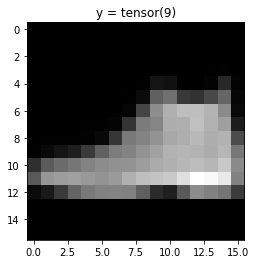

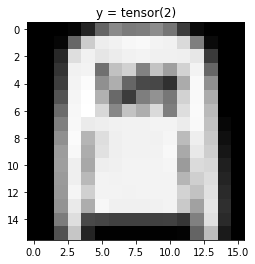

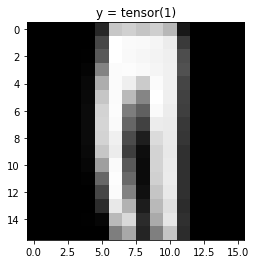

In [5]:
# Create a transform to resize image and convert to tensor
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

# Create Dataset from MNIST and apply composed transformation
dataset_train = dsets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=composed)
dataset_val = dsets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=composed)

for n, data_sample in enumerate(dataset_val):

    show_data(data_sample)
    plt.show()
    if n == 2:
        break

### Question: Take a screen shot of the first three images of the validation dataset from the code provided.

## The function show_data              

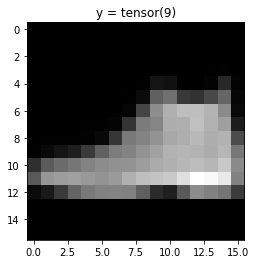

In [6]:
show_data(dataset_val[0])


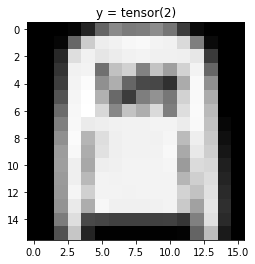

In [7]:
show_data(dataset_val[1])


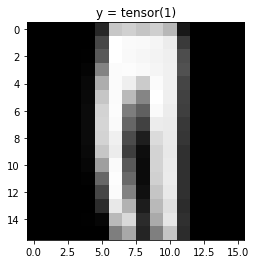

In [8]:
show_data(dataset_val[2])

#### Create CNN Class

In [9]:
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.ELU = nn.ELU()
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2*4*4, 10)

            # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.ELU(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.ELU(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs in each step
    def activations(self, x):
        # This part is for visualization purposes
        z1 = self.cnn1(x)
        a1 = self.ELU(z1)
        out = self.maxpool1(a1)
        z2 = self.cnn2(out)
        a2 = self.ELU(z2)
        out1 = self.maxpool2(a2)
        out2 = out1.view(out1.size(0), -1)
        return z1, a1, out, z2, a2, out1, out2

### Batch Normalization CNN class

In [10]:
class CNN_BatchNorm(nn.Module):
    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)  # To normalize conv2D, we need BatchNorm2D
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.ELU = nn.ELU()
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2*4*4, 10)
        self.bn_fc1 = nn.BatchNorm1d(10)  # To normalize linear layer, BatchNorm1D must be used

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.ELU(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = self.ELU(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x


### Initialize, create loss function, optimizer and data loaders

In [11]:
# Loss function criterion
criterion = nn.CrossEntropyLoss()

In [12]:
# train and val loader
train_loader = DataLoader(dataset=dataset_train, batch_size=100)
validation_loader = DataLoader(dataset=dataset_val, batch_size=100)

In [13]:
# Create model_BatchNorm object from CNN_BatchNorm class
model = CNN_BatchNorm(16, 32)

In [15]:
model

CNN_BatchNorm(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ELU): ELU(alpha=1.0)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
  (bn_fc1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Train loop and training

In [ ]:
start_time = time.time()

cost_list = []
accuracy_list = []
N_test = len(dataset_val)
n_epochs = 5
for epoch in range(n_epochs):
    cost = 0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    correct = 0
    # Perform a prediction on the validation data
    model.eval()
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)

### Analyze Results and Compare

In [ ]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [ ]:
fig()

In [ ]:
fig.show()